# Optimal adaptation model plots
#### Author: Eddie Lee, edlee@csh.ac.at  

This notebook is for plotting the results from the manuscript "Outsourcing Memory Through Niche Construction" by Edward D. Lee, Jessica C. Flack, David C. Krakauer.

In [1]:
%matplotlib inline

In [2]:
plt.rc('font', size=25)

In [4]:
from pyutils import *
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# set path to where figures will be saved
imgdr = os.path.expanduser('~')+'/Dropbox/Research/learning/writing/20210227_draft'
assert os.path.exists(imgdr), "Set local directory for saving plot images."

# Part of Figure 1

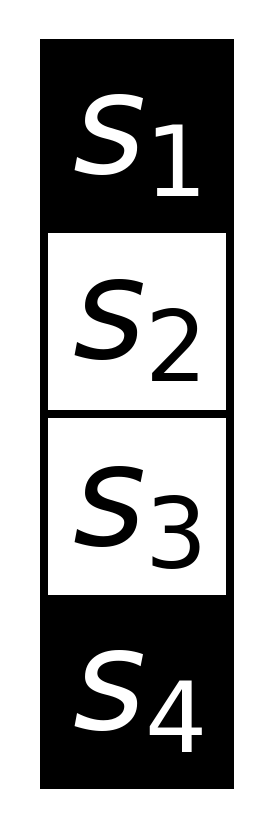

In [63]:
patches = []

for i in range(4):
    patches.append(Rectangle((0,i*10), 10, 10, lw=8, ec='k', color='w' if random.rand()<.5 else 'k'))

fig, ax = plt.subplots(figsize=(10,15),
                       subplot_kw={'aspect':'equal'})

for i, p in enumerate(patches):
    ax.add_patch(p)
    if sum(p.get_fc())==1:
        ax.text(1.5, 3+10*i, r'$s_%d$'%(4-i), fontsize=140, color='w')
    else:
        ax.text(1.5, 3+10*i, r'$s_%d$'%(4-i), fontsize=140)
    
ax.set(xlim=(-2,12), ylim=(-2, 42), xticks=[], yticks=[])
[s.set_visible(False) for s in ax.spines.values()];

In [147]:
fig.savefig('%s/vector.png'%imgdr, bbox_inches='tight', dpi=200)

# Part of Figure 1

In [29]:
seed = 1

# agent properties
betaRange = np.exp(-1/np.array([1,10,100]))
# environment properties
tau = 10
kwargs = {'noise':{'type':'binary', 'scale':.2},
          'T':10_000,
          'nBatch':1_000}

kwargs['rng'] = np.random.RandomState(seed)
kwargs['noise']['tau'] = tau
learner = agent.Passive(**kwargs)
learner.learn(betaRange);

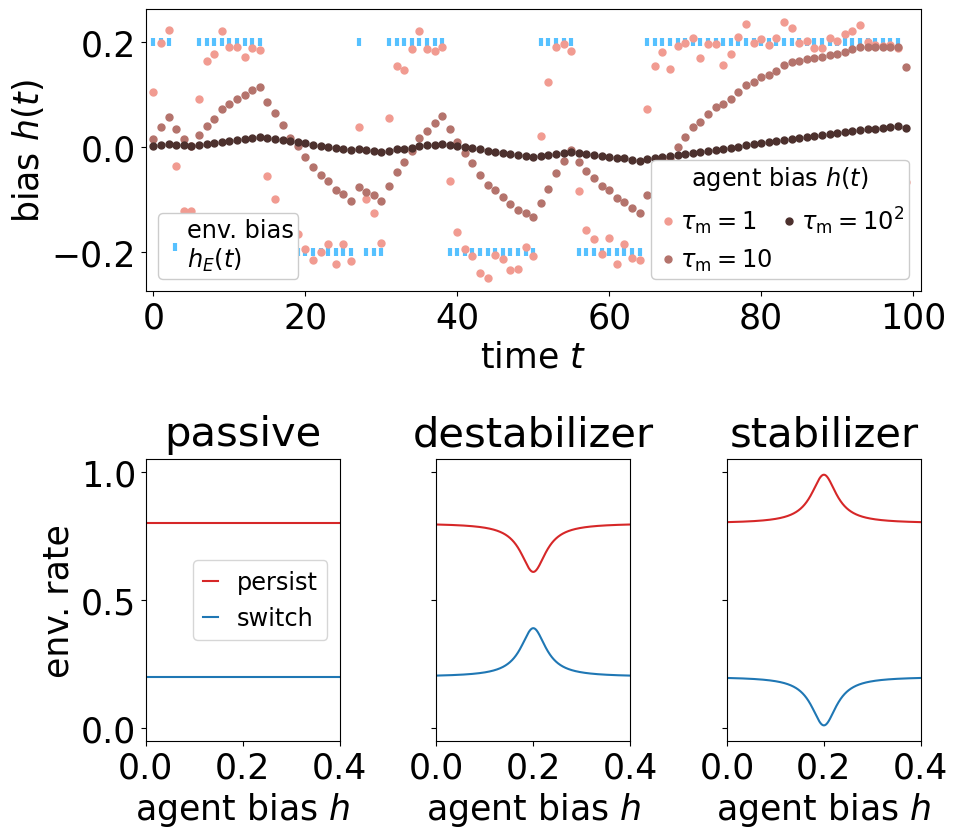

In [30]:
fig = plt.figure(figsize=(10,9.5))
gs = GridSpec(2,3)

# example trajectory ===================================
ax = fig.add_subplot(gs[0,:])

h = []

ix = np.where(learner.h[:100]>0)[0]
ax.plot(ix, learner.h[:100][ix], '|', c='#56C1FF', mew=3)
ix = np.where(learner.h[:100]<0)[0]
h.append(ax.plot(ix, learner.h[:100][ix], '|', c='#56C1FF', mew=3)[0])
h.append(ax.plot(learner.hhat[betaRange[0]][:100], '.', c='#F19B91', ms=10)[0])
h.append(ax.plot(learner.hhat[betaRange[1]][:100], '.', c='#B4736C', ms=10)[0])
h.append(ax.plot(learner.hhat[betaRange[2]][:100], '.', c='#4C302D', ms=10)[0])

ax.set(xlabel=r'time $t$', ylabel=r'bias $h(t)$', xlim=(-1,101))

# h.insert(0, Line2D([0], [0], marker='|', mew=3, ms=8, color='k', linewidth=0))
leg1 = ax.legend(h[:1], ('env. bias\n'+r'$h_E(t)$',),
                 fontsize='x-small', handletextpad=.0, borderpad=.2, ncol=2, handlelength=1,
                 columnspacing=.2, framealpha=1, loc=3)
leg2 = ax.legend(h[1:],
                  (r'$\tau_{\rm m}=1$', r'$\tau_{\rm m}=10$', r'$\tau_{\rm m}=10^2$'),
                  fontsize='x-small', handletextpad=.0, borderpad=.2, ncol=2, handlelength=1,
                  columnspacing=.2, framealpha=1, loc=4)
leg2.set_title(r'agent bias $h(t)$', prop={'size':'x-small'})
ax.add_artist(leg1)


# rate forms ============================================
ax = [fig.add_subplot(gs[1,i]) for i in range(3)]

h = np.linspace(0, .4, 1000)
h0 = .2
tau = 5
vd = .001  # dissipation
vs = .001  # stabilization
weight = .95


# passive
hand = []
hand.append(ax[0].plot(h, np.zeros_like(h)+1/tau)[0])
hand.append(ax[0].plot(h, np.ones_like(h)-1/tau, c='C3')[0])
ax[0].set(xlabel=r'agent bias $h$', ylabel=r'env. rate')
ax[0].set_title('passive', pad=10)
ax[0].legend(hand[::-1], ('persist', 'switch'),
             fontsize='x-small', handlelength=.6)

# destabilizer
stay = binary_env_stay_rate(h-h0, tau, vd, -weight)
decay = 1 - stay

ax[1].plot(h, decay)
ax[1].plot(h, stay, c='C3')
ax[1].set(xlabel=r'agent bias $h$')
ax[1].set_title('destabilizer', pad=10)

# stabilizer
stay = binary_env_stay_rate(h-h0, tau, vs, weight)
decay = 1 - stay

ax[2].plot(h, decay)
ax[2].plot(h, stay, c='C3')
ax[2].set_title('stabilizer', pad=10)


for a in ax:
    a.set(xlabel=r'agent bias $h$', xlim=(0,.4),
          xticks=(0,.2,.4),
          ylim=(-.05,1.05))
for a in ax[1:]:
    a.set(yticklabels=[])
    
fig.subplots_adjust(wspace=.5, hspace=.6)

In [7]:
fig.savefig(f'{imgdr}/example_and_rates.pdf', bbox_inches='tight')

# Figure 2

Text(0.628, 0.128, '(d)')

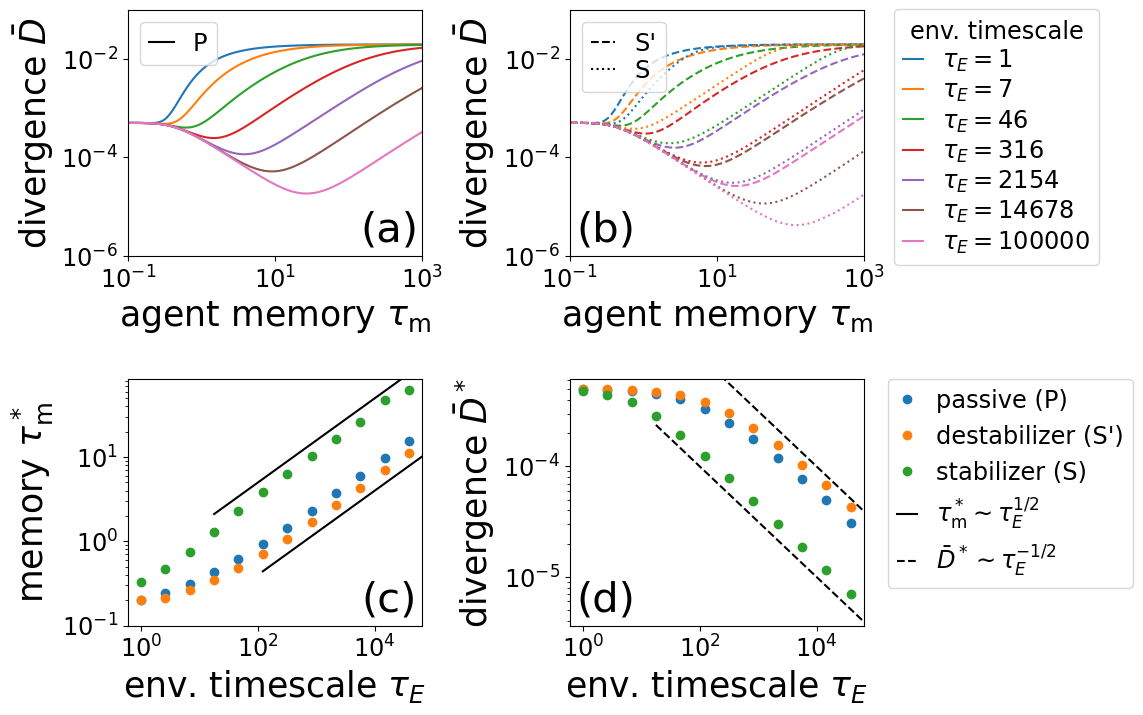

In [27]:
load_pickle('cache/passive_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
dkl_ = dkl.copy()
for k in list(dkl.keys())[1::2]:
    del dkl[k]

fig, ax = plt.subplots(figsize=(9.5,8), ncols=2, nrows=2,
                       gridspec_kw={'wspace':.5,'hspace':.5})
allax = ax
ax = [ax[0,0],ax[0,1]]


for i, mdkl in enumerate(dkl.values()):
    ax[0].loglog(-1/np.log(betaRange), mdkl, '-', c='C%d'%i)

ax[0].set(ylabel=r'divergence $\bar D$',
          xlim=-1/np.log(betaRange[[0,-1]]), ylim=(1e-6, .1),
          xlabel=r'agent memory $\tau_{\rm m}$',
          xticks=[.1, 10, 1e3])
leg = ax[0].legend([r'$\tau_E=%1.0f$'%(i) for i in tauRange],
                   fontsize='x-small',
                   loc=1,
                   ncol=1,
                   handlelength=.8,
                   columnspacing=.7,
                   handletextpad=.8,
                   labelspacing=.17,
                   bbox_to_anchor=(3.34,1.049))
leg.set_title('env. timescale',
              prop={'size':'x-small'})
leg.remove()

load_pickle('cache/destabilizer_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
dkl_ = dkl.copy()
for k in list(dkl.keys())[1::2]:
    del dkl[k]

for i, mdkl in enumerate(dkl.values()):
     ax[1].loglog(-1/np.log(betaRange), mdkl, '--')
        
load_pickle('cache/stabilizer_agent_sim_tau_range.p')
tauRange_ = tauRange
learners_ = learners
tauRange = tauRange[::2]
learners = learners[::2]
for k in list(dkl.keys())[1::2]:
    del dkl[k]

for i, mdkl in enumerate(dkl.values()):
     ax[1].loglog(-1/np.log(betaRange), mdkl, ':',
              c='C%d'%i)

ax[1].set(xlabel=r'agent memory $\tau_{\rm m}$',
          ylabel=r'divergence $\bar D$',
          xlim=-1/np.log(betaRange[[0,-1]]),
          ylim=(1e-6, .1),
          xticks=[.1, 10, 1e3])

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], linestyle='--', color='k'),
                Line2D([0], [0], linestyle=':', color='k')]
ax[0].legend(custom_lines,
             ('P',),
             fontsize='x-small',
             handlelength=1,
             labelspacing=.15,
             loc=2)
custom_lines = [Line2D([0], [0], linestyle='--', color='k'),
                Line2D([0], [0], linestyle=':', color='k')]
ax[1].legend(custom_lines,
             ("S'",'S'),
             fontsize='x-small',
             handlelength=1,
             labelspacing=.15,
             loc=2)
ax[1].add_artist(leg)



# ===============================================
ax = [allax[1,0],allax[1,1]]

# track min
# load_pickle('cache/tau_scaling_0.2.p')
load_pickle('cache/eigen_passive_tau_range.p')

h = []

# passive
minbeta = []
mindkl = []
for k in list(edkl.keys())[:-1]:
    mn = find_chebmin(betaRange, edkl[k], h0, errs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/np.log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# destabilizer
load_pickle('cache/eigen_destabilizer_tau_range.p')
minbeta = []
mindkl = []
for k in list(edkl.keys())[:-1]:
    mn = find_chebmin(betaRange, edkl[k], h0, errs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/np.log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# stabilizer ===================================
load_pickle('cache/eigen_stabilizer_tau_range.p')
minbeta = []
mindkl = []
for k in list(edkl.keys())[:-1]:
    mn = find_chebmin(betaRange, edkl[k], h0, errs[k].ravel())
    minbeta.append(mn[0])
    mindkl.append(mn[1])
minbeta = np.array(minbeta)
mindkl = np.array(mindkl)
memlifetime = -1/np.log(minbeta)
h.append(ax[0].loglog(tauRange[:memlifetime.size], memlifetime, 'o')[0])
ax[1].loglog(tauRange[:mindkl.size], mindkl, 'o')

# fit lines ====================================
xlim0 = ax[0].get_xlim()
ylim0 = ax[0].get_ylim()
te = np.array([tauRange[5], xlim0[-1]])
h.append(ax[0].loglog(te, te**.5/25, 'k-')[0])
te = np.array([tauRange[3], xlim0[-1]])
ax[0].loglog(te, te**.5/2, 'k-')

ylim = ax[1].get_ylim()
te = tauRange[3:]
h.append(ax[1].loglog(te, te**-.5/1000, 'k--')[0])
te = tauRange[4:]
ax[1].loglog(te, te**-.5/100, 'k--')

ax[0].set(ylabel=r'memory $\tau_{\rm m}^*$')
ax[0].set(xscale='log', yscale='log')
ax[0].set(xlim=xlim0, ylim=(.1, ylim0[1]),
          xlabel=r'env. timescale $\tau_E$',
          xticks=[1, 1e2, 1e4])
ax[1].set(xscale='log', yscale='log',
          xlabel=r'env. timescale $\tau_E$',
          ylabel=r'divergence $\bar D^*$')
ax[1].set(xlim=xlim0, ylim=ylim)
ax[1].set(ylim=(4e-6/1.1,ylim[1]),
          xticks=[1, 1e2, 1e4])

ax[1].legend(h, ('passive (P)', "destabilizer (S')", 'stabilizer (S)',
                 r'$\tau_{\rm m}^* \sim \tau_E^{1/2}$',
                 r'$\bar D^* \sim \tau_E^{-1/2}$'),
             fontsize='x-small',
             handlelength=.8,
             loc=1,
             bbox_to_anchor=(1.955,1.051))


# formatting all axes =============================================
for a in allax.ravel():
    [el.set_fontsize('x-small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('x-small') for el in a.yaxis.get_ticklabels()]

# allax[0,0].text(140, 2e-6, '(a)', fontsize=30)
# allax[0,1].text(.12, 2e-6, '(b)', fontsize=30)
fig.text(.4, .59, '(a)', fontsize=30, ha='center')
fig.text(.628, .59, '(b)', fontsize=30, ha='center')
fig.text(.4, .128, '(c)', fontsize=30, ha='center')
fig.text(.628, .128, '(d)', fontsize=30, ha='center')

In [28]:
fig.savefig(f'{imgdr}/tau_scaling.pdf', bbox_inches='tight')

# Figure 3

In [31]:
load_pickle('plotting/vision_benefits.p')

['scaleRange',
 'nBatchRange',
 'leftGrid',
 'rightGrid',
 'optimalMemGrid',
 'optunfitness']

/tmp/ipykernel_223740/1995172059.py:4: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(leftGrid)


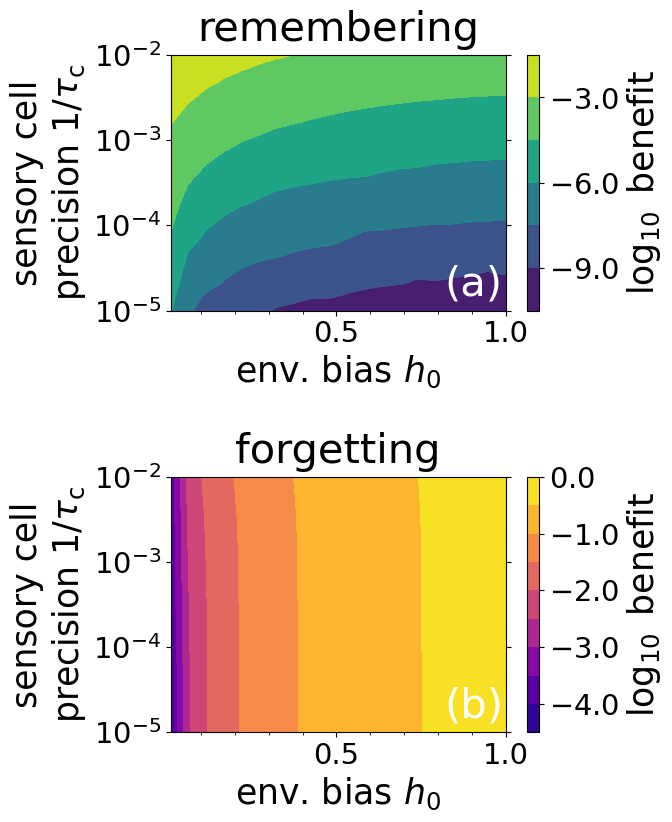

In [35]:
fig, ax = plt.subplots(figsize=(5.4,8.8), nrows=2)

# remembering
mat = np.log10(leftGrid)
mat[mat==-np.inf] = np.log10(leftGrid[leftGrid>0].min())
mat[mat<-10] = -10
cax = ax[0].contourf(scaleRange, 1/nBatchRange, mat, np.arange(-10.5,0,1.5))
ax[0].set(ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$',
          yscale='log', xlabel=r'env. bias $h_0$')
ax[0].set_title('remembering', pad=10)
cbar = fig.colorbar(cax, ax=ax[0],
                    ticks=np.arange(-9,0,3),
                    label=r'$\log_{10}$ benefit', format='$%1.1f$')
labels = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(labels, fontsize='small')

# forgetting
cax = ax[1].contourf(scaleRange, 1/nBatchRange, np.log10(rightGrid),
                     cmap=plt.cm.plasma)
ax[1].set(xlabel=r'env. bias $h_0$', ylabel='sensory cell\n'+r'precision $1/\tau_{\rm c}$',
          yscale='log')
ax[1].set_title('forgetting', pad=10)
cbar = fig.colorbar(cax, ax=ax[1],
                    ticks=range(-4,1),
                    label=r'$\log_{10}$ benefit',
                    format='%1.1f')
labels = cbar.ax.get_yticklabels()
[el.set_text(r'$%s$'%el.get_text()) for el in labels]
cbar.ax.set_yticklabels(labels, fontsize='small')

# formatting
for ax_ in ax:
    ax_.set(yscale='log')
    ax_.xaxis.set_ticks(np.arange(.1,1.1,.1), minor=True)
    ax_.yaxis.set_ticks_position('both')
ax[0].set(yticks=[1e-2,1e-3,1e-4,1e-5], xticks=[.5,1])
ax[1].set(yticks=[1e-2,1e-3,1e-4,1e-5], xticks=[.5,1])

fig.subplots_adjust(hspace=.65)

ax[0].text(.82, 1.5e-5, '(a)', color='white', size=30)
ax[1].text(.82, 1.5e-5, '(b)', color='white', size=30)

for a in ax.ravel():
    [el.set_fontsize('small') for el in a.xaxis.get_ticklabels()]
    [el.set_fontsize('small') for el in a.yaxis.get_ticklabels()]

fig.savefig('%s/memory_v_forgetting.pdf'%imgdr, bbox_inches='tight')

# Part of Figure 4

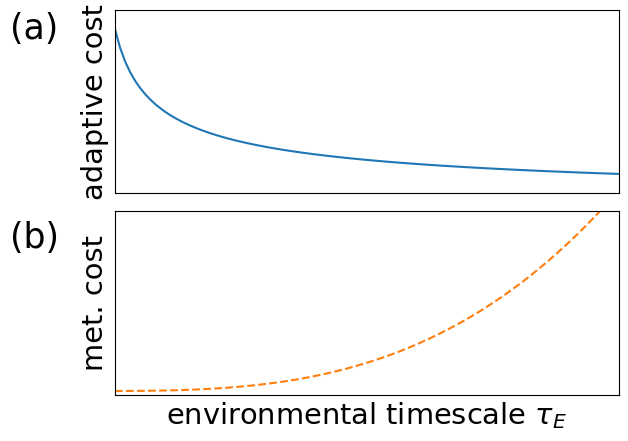

In [36]:
Ne = np.linspace(.1, 2.5, 100)

fig, ax = plt.subplots(figsize=(6.5,5), nrows=2, sharex=True)
h = []
te = np.linspace(.1, 2.5, 100)

h.append(ax[0].plot(te, te**-.5, '-')[0])

ax[0].set(xticks=[], yticks=[],
          ylim=(.3,3.5),
          xlim=(Ne.min(), Ne.max()))
ax[0].set_ylabel(r'adaptive cost', fontsize='small')

h.append(ax[1].plot(te, .1 + te**3*.35, '--', c='C1')[0])

ax[1].set(xticks=[], yticks=[],
          ylim=(0, 5),
          xlim=(te.min(), te.max()))
ax[1].set_xlabel(r'environmental timescale $\tau_E$', fontsize='small')
ax[1].set_ylabel(r'met. cost', fontsize='small') 

# ax[1].legend(h[1:], (r'$\phi=1$',),
#              fontsize='xx-small',
#              handlelength=1,
#              loc=2,
#              ncol=1)

ax[0].text(-.4, 3, '(a)')
ax[1].text(-.4, 4, '(b)')

fig.subplots_adjust(hspace=.1)
fig.savefig(f'{imgdr}/metabolic_scaling.pdf', bbox_inches='tight')

# SI Figures

# Figure S1

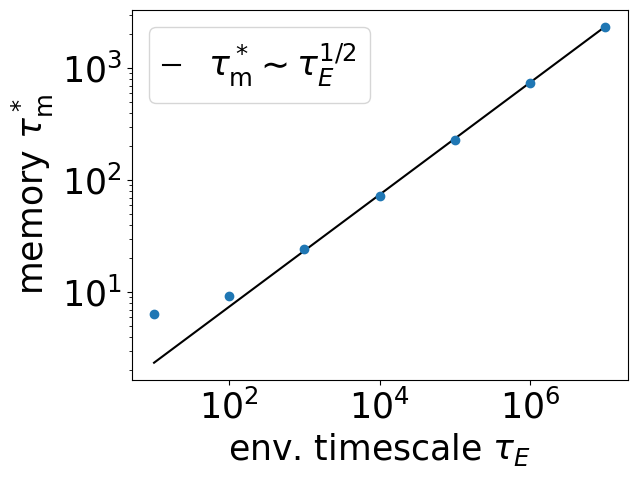

In [58]:
load_pickle('cache/kalman_ex.p')

t_m = -1/np.log(1-gain)
t_opt = []
for t, d in zip(t_m, div):
    f = interp1d(np.log(t), np.log(d), kind='cubic')
    t_opt.append(np.exp(minimize(f, np.log(t[10]), bounds=[(np.log(t[-1]), np.log(t[0]))])['x']))

t_env = 1/p_range

fig, ax = plt.subplots()
ax.loglog(t_env, t_opt, 'o', zorder=1)
a = .5
ax.loglog(t_env, t_env**a/t_env[-1]**a * t_opt[-1], 'k-',
          label=r'$\tau_{\rm m}^* \sim \tau_E^{1/2}$',
          zorder=0)
ax.set(xlabel=r'env. timescale $\tau_E$', ylabel=r'memory $\tau_{\rm m}^*$')
ax.legend(handlelength=.5)

fig.savefig(f'{imgdr}/kalman_ex.pdf', bbox_inches='tight')

## Figure S2

In [43]:
tau = 20  # time scale for flipping external field
h0 = .2  # magnitude of external field
nBatch = 10_000
betaRange = [0,1/9,2/9,3/9]

load_pickle('cache/abs_passive_example_tau=%d.p'%tau)
# remember h is fixed for passive sim
ix = (abs(learner.h)<=np.inf) & (learner.h>0)
ix[:1000] = False

simx, simp = {}, {}
eigx, eigp = {}, {}
bins = np.linspace(-1, 1, 1000)

for beta in betaRange:
    p, x = np.histogram(learner.hhat[beta][ix], bins=bins)
    x = (x[1:] + x[:-1]) / 2
    p = p / p.sum()
    p /= bins[1] - bins[0]
    simx[beta] = x
    simp[beta] = p

    solver = eigen.Passive(tau, h0, beta, nBatch, dx=1e-3)
    # check that external conditioning still sums to the full solution
    phatavg, errflag, errs = solver.solve_external_cond()
    eigx[beta] = solver.x
    eigp[beta] = phatavg

Done in 1 steps.
Done in 7 steps.
Done in 10 steps.
Done in 14 steps.


[(0.0, 0.3), Text(0.5, 0, 'agent bias $h$')]

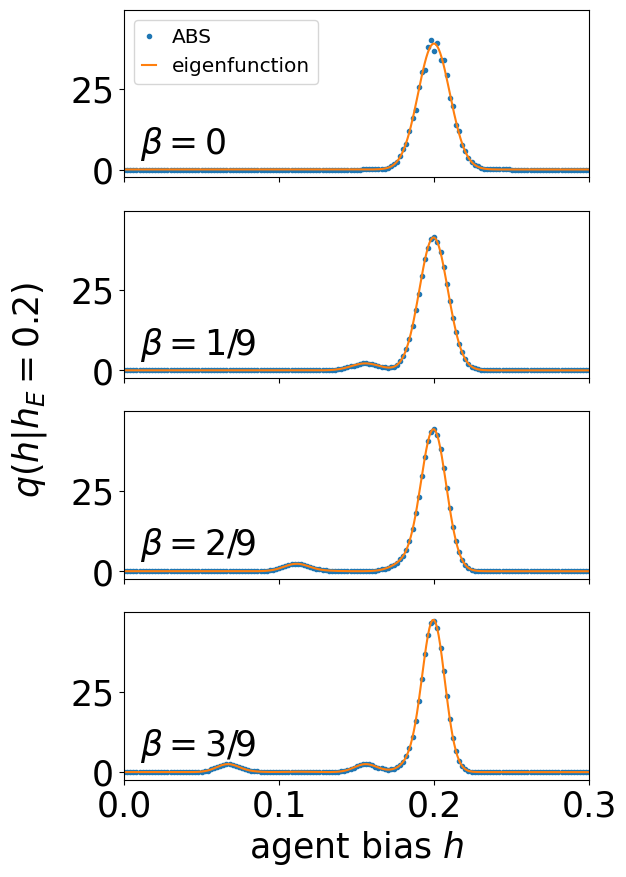

In [44]:
fig, ax = plt.subplots(figsize=(6,10), nrows=len(betaRange),
                       sharex=True, sharey=True)
ax = ax.ravel()

for i, beta in enumerate(betaRange):
    ax[i].plot(simx[beta], simp[beta], '.')
    ax[i].plot(eigx[beta], eigp[beta], '-')
    if i==0:
        ax[i].text(.01, 5, r'$\beta=0$')
    else:
        ax[i].text(.01, 5, r'$\beta=%d/9$'%i)

    
ax[0].legend(('ABS', 'eigenfunction'),
             fontsize='xx-small',
             handlelength=.7)

fig.text(0,.5, r'$q(h|h_E=0.2)$', rotation='vertical',
         horizontalalignment='right',
         verticalalignment='center')

ax[i].set(xlim=(0,.3), xlabel=r'agent bias $h$')
fig.savefig('%s/vision_cond_prob_check.pdf'%imgdr, bbox_inches='tight')

In [48]:
tau = 20  # time scale for flipping external field
h0 = .2  # magnitude of external field
nBatch = 10_000

load_pickle('cache/abs_active_example_tau=%d.p'%tau)
betaRange = [0,1/9,2/9,3/9]

simx, simp = {}, {}
eigx, eigp = {}, {}
bins = np.linspace(-1, 1, 1000)

for beta in betaRange:
    ix = (abs(learner.h[beta])<=np.inf) & (learner.h[beta]>0)
    ix[:1000] = False
    
    p, x = np.histogram(learner.hhat[beta][ix], bins=bins)
    x = (x[1:]+x[:-1])/2
    p = p / p.sum()
    p /= bins[1] - bins[0]
    simx[beta] = x
    simp[beta] = p

    solver = eigen.Active(tau, h0, beta, nBatch, dx=1e-3)
    # check that external conditioning still sums to the full solution
    phatavg, errflag, errs = solver.solve_external_cond()
    eigx[beta] = solver.x
    eigp[beta] = phatavg

Done in 1 steps.
Done in 8 steps.
Done in 11 steps.
Done in 15 steps.


[(0.0, 0.3), Text(0.5, 0, 'agent bias $h$')]

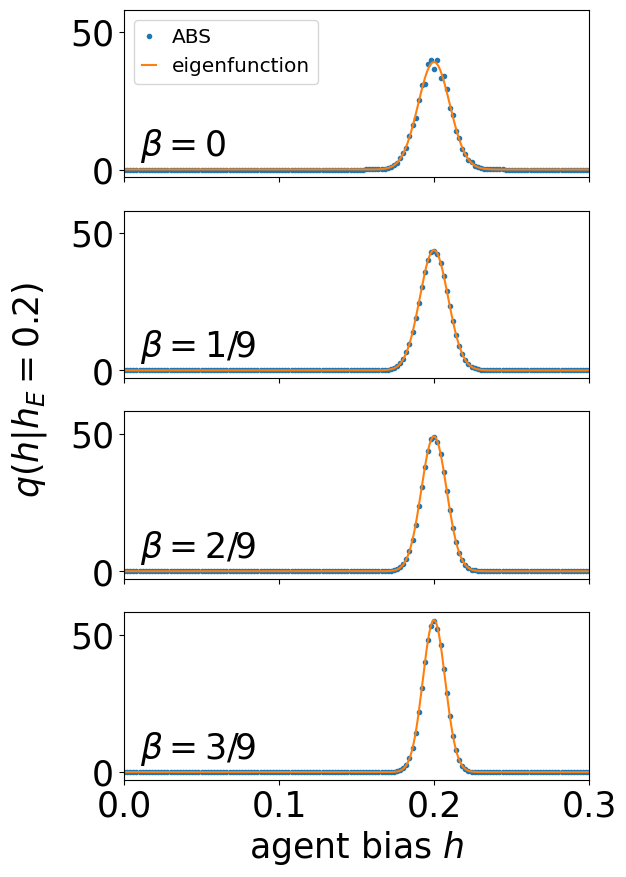

In [49]:
fig, ax = plt.subplots(figsize=(6,10), nrows=len(betaRange),
                       sharex=True, sharey=True)
ax = ax.ravel()

for i, beta in enumerate(betaRange):
    ax[i].plot(simx[beta], simp[beta], '.')
    ax[i].plot(eigx[beta], eigp[beta], '-')
    if i==0:
        ax[i].text(.01, 5, r'$\beta=0$')
    else:
        ax[i].text(.01, 5, r'$\beta=%d/9$'%i)
    
ax[0].legend(('ABS', 'eigenfunction'),
             fontsize='xx-small',
             handlelength=.7)

fig.text(0,.5, r'$q(h|h_E=0.2)$', rotation='vertical',
         horizontalalignment='right',
         verticalalignment='center')

ax[i].set(xlim=(0,.3), xlabel=r'agent bias $h$')
fig.savefig('%s/stig_cond_prob_check.pdf'%imgdr, bbox_inches='tight')

## Figure S3

In [37]:
load_pickle('plotting/chebyshev_convergence.p')

['degreeRange', 'ldkl', 'lstabCost', 'dkl', 'errs', 'cost', 'h0', 'tau']

Text(300.0, 0.245, 'B')

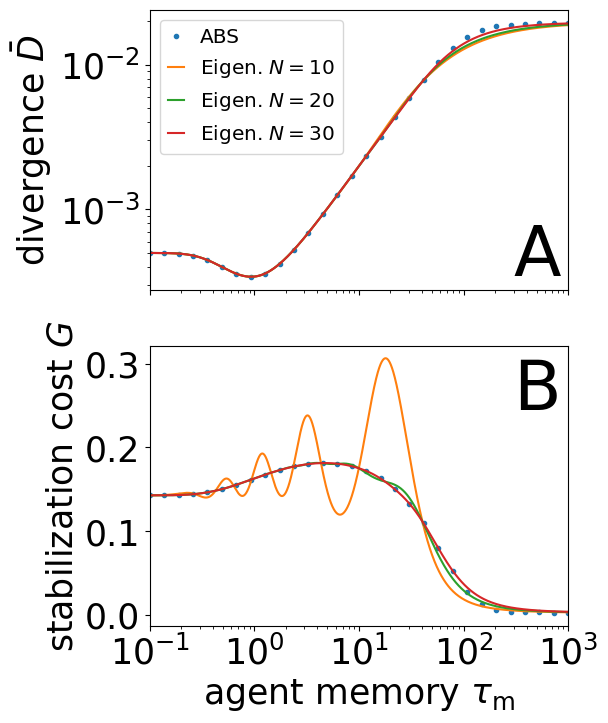

In [41]:
fig, ax = plt.subplots(figsize=(5.4, 8), nrows=2, sharex=True)

betaRange = linspace_beta(.1, 1000, 30)
ax[0].plot(-1/np.log(betaRange), ldkl, '.')

betaPlot = np.linspace(betaRange[0], .9999, 10000)
for i, d in enumerate(degreeRange):
    spline = interpolate(lobatto_beta(d), dkl[i], h0, errs=errs[i].ravel())
    ax[0].plot(-1/np.log(betaPlot), spline(betaPlot))

ax[0].set(ylabel=r'divergence $\bar D$',
          xscale='log', yscale='log')
ax[0].legend(('ABS', 'Eigen. $N=10$', 'Eigen. $N=20$', 'Eigen. $N=30$'),
             handlelength=.8,
             fontsize='xx-small')


betaRange = linspace_beta(.1, 1000, 30)
ax[1].plot(-1/np.log(betaRange), lstabCost, '.')

betaPlot = np.linspace(betaRange[0], .9999, 10000)
deg = np.zeros(len(degreeRange))
for i, d in enumerate(degreeRange):
    spline = interpolate_cost(lobatto_beta(d), cost[i], errs[i].ravel(), h0, tau,
                              {'weight':.95,'v':.01})
    deg[i] = (errs[i]<1e-4).sum()
    ax[1].plot(-1/np.log(betaPlot), spline(betaPlot))

ax[1].set(xlabel=r'agent memory $\tau_{\rm m}$', ylabel=r'stabilization cost $G$',
          xscale='log')
ax[1].set(xlim=(-1/np.log(betaRange[0]), -1/np.log(betaRange[-1])))

ax[0].text(3e2, 3.5e-4, 'A', fontsize=50)
ax[1].text(3e2, .245, 'B', fontsize=50)

fig.savefig('%s/chebyshev_convergence.pdf'%imgdr, bbox_inches='tight')